# CARTE-Enbridge Bootcamp
#### Lab 3

# Predictive Maintenance

In this lab, we are going to take a look at using machine learning to predict when a machine will fail, so you can perform maintenance before it does, or better understand the factors that lead to failure. This is called *predictive maintenance*, and it is a common application of machine learning in industry.

## The Data

The data we are going to use is a synthetic (simulated) dataset modelled after a milling machine used in industrial applications. It was created to assist in measuring model performance for a scientific conference. The original dataset is available [here](https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020). The data is available as a CSV file, which we will read into a Pandas dataframe:

In [1]:
import pandas as pd

data = pd.read_csv("https://github.com/alexwolson/carte_workshop_datasets/raw/main/ai4i2020.csv.zip", compression="zip")

In [2]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


As we can see, the data includes a number of features that might be useful in predicting when a machine is likely to fail. The **UDI** column is a unique identifier for each machine, and the **Product ID** column identifies the specific model of machine. The remaining columns (**Air temperature**, **Process temperature**, **Rotational speed**, **Torque**, **Tool wear**, and **Machine failure**) are numeric values that indicate the machine's operating characteristics at a point in time. The **Machine failure** column indicates whether the machine failed in the following hour (1) or not (0). The remaining fields represent different modes of failure:

- TWF: Tool Wear Failure
- HDF: Heat Dissipation Failure
- PWF: Power Failure
- OSF: Overspeed Failure
- RNF: Random Failure

We are going to begin by just predicting whether the machine is going to fail or not, but we can come back to the specific failure modes later.

Let's start by pre-processing our data. We are going to rely on many helpful functions from the [scikit-learn](https://scikit-learn.org/stable/) library, so let's import that now:

In [3]:
from sklearn import preprocessing

First, we need to split our data into features and labels. The **UDI** and **Product ID** columns are not useful for predicting machine failure, so we can drop them. The **Machine failure** column is our target, so we can drop that from the features and assign it to a separate variable:

In [4]:
labels = data["Machine failure"]
features = data.drop(
    ["UDI", "Product ID", "Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"], axis=1
)

The `type` column is a categorical value, so we need to encode it numerically. We can use the `LabelEncoder` class from scikit-learn to do this. Like encoding that we've done before, `LabelEncoder` will assign a unique value to each category, and replace the original value.

In [5]:
le = preprocessing.LabelEncoder()
le.fit(features["Type"])
features["Type"] = le.transform(features["Type"])

features

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,2,298.1,308.6,1551,42.8,0
1,1,298.2,308.7,1408,46.3,3
2,1,298.1,308.5,1498,49.4,5
3,1,298.2,308.6,1433,39.5,7
4,1,298.2,308.7,1408,40.0,9
...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14
9996,0,298.9,308.4,1632,31.8,17
9997,2,299.0,308.6,1645,33.4,22
9998,0,299.0,308.7,1408,48.5,25


It's often helpful to visualize our features to get a sense of what pre-processing we might need to do. We can use the `hist` method of the Pandas dataframe to plot histograms of each feature. It conveniently ignores the categorical features, so we don't have to worry about those, and generates plots for each of the numerical features.

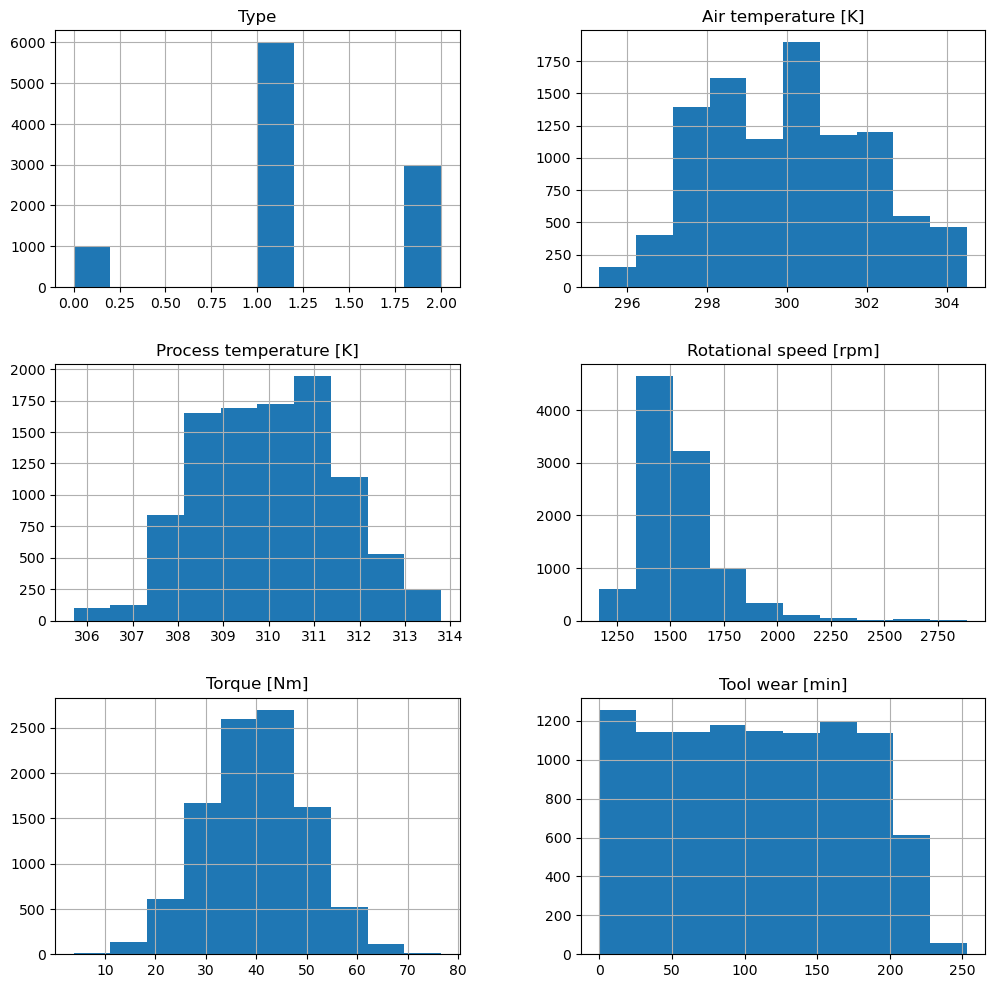

In [6]:
features.hist(figsize=(12, 12));

The features are all on different scales, so normalizing them will help to ensure that they get considered with equal weight in the model. Scikit-Learn provides a `MinMaxScaler` class that will scale our numeric features to a value between 0 and 1:

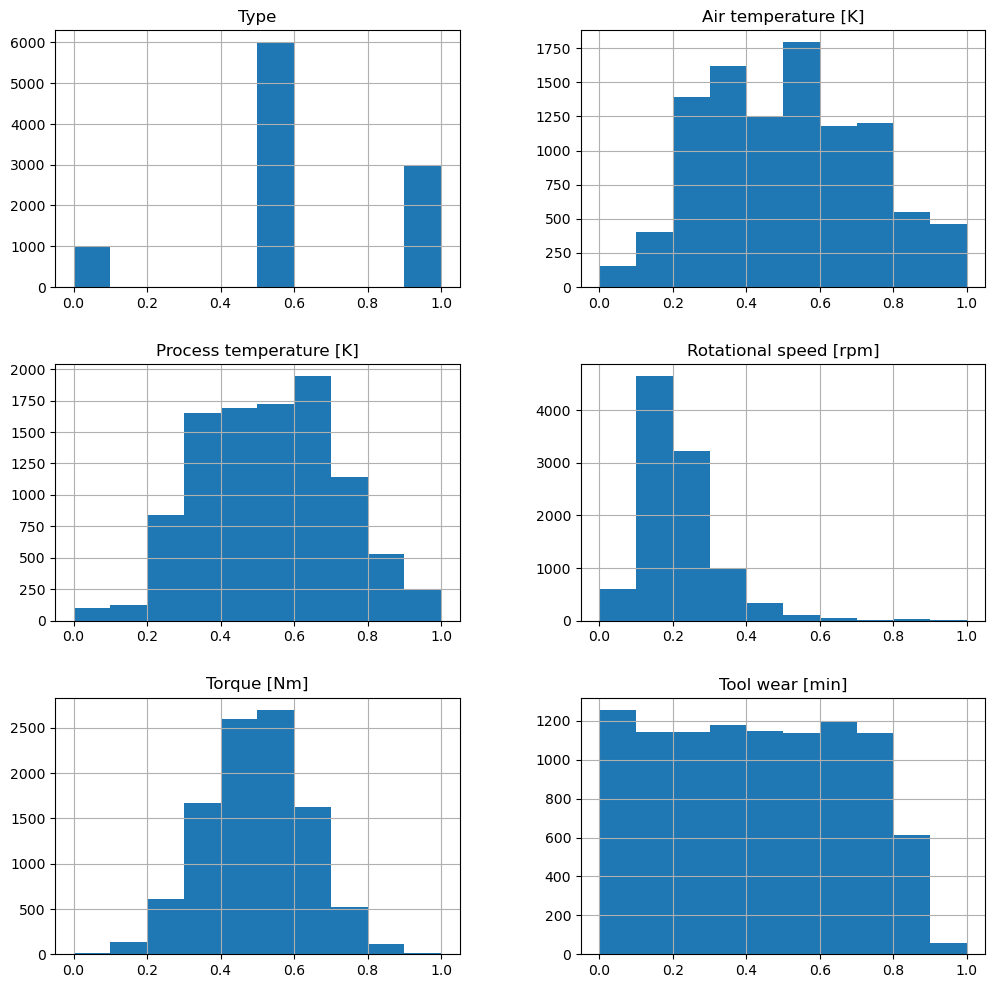

In [7]:
scaler = preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, columns=features.columns)
features.hist(figsize=(12, 12));

Looking good! Now we have our features and labels prepared, we can split them into training and test sets. We'll use our old friend the `train_test_split` function from scikit-learn to do this. We'll use 20% of the data for testing, and the remaining 80% for training. We'll also set the `random_state` parameter to 0 so that we get the same split every time we run the code. This is useful for reproducibility.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=0
)

print("Training Set: %d, Test Set: %d \n" % (x_train.shape[0], x_test.shape[0]))

Training Set: 8000, Test Set: 2000 


## Train a Classification Model

Scikit-Learn includes a variety of machine learning algorithms that we can use to train a classification model. Let's try a simple logistic regression model first. We are going to measure the time it takes each of our models to train today, so we can compare them later.

In [9]:
from sklearn.linear_model import LogisticRegression
from time import time

lr = LogisticRegression()
start_time = time()
lr.fit(x_train, y_train)
print(f'Training time: {time() - start_time:.2f}s')

Training time: 0.01s


The way that we measure the performance of a model is dependent on the task that we are performing. When it comes to predictive maintenance, it's probably more important that we don't miss a machine failure than it is to avoid false alarms. In other words, we want to minimize the number of *false negatives* (predicting that the machine will not fail in the next hour when it actually does) rather than the number of *false positives* (predicting that the machine will fail when it actually doesn't). 

We can calculate these metrics directly:

In [10]:
import numpy as np


def get_negatives_metrics(x, y, model):
    y_hat = model.predict(x)
    false_negatives = np.logical_and((y_hat == 0), (y == 1)).sum()
    false_positives = np.logical_and((y_hat == 1), (y == 0)).sum()
    return false_negatives, false_positives

In [11]:
false_negatives, false_positives = get_negatives_metrics(x_test, y_test, lr)
print(f"False Negatives: {false_negatives}, False Positives: {false_positives}")

False Negatives: 75, False Positives: 0


As we can see, the Logistic Regression model has way too many false negatives to be useful for predictive maintenance. Another way to look at this is using a balanced accuracy score. While the standard accuracy metric is the number of correct predictions divided by the total number of predictions, the balanced accuracy score is the average of the recall obtained on each class. In other words, it's the average of the true positive rate and the true negative rate. We can calculate this using the `balanced_accuracy_score` function from scikit-learn:

In [12]:
from sklearn.metrics import balanced_accuracy_score

print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, lr.predict(x_test)) * 100:.2f}%"
)

Balanced accuracy: 50.00%


50% accuracy for a binary task means that our model is no better than a coin flip. Clearly, this Logistic Regression model is not going to be useful for predictive maintenance. Let's try a more sophisticated algorithm - a decision tree. In order to help with visualization, we're going to limit the depth of the tree to 3 - this means that the tree will only ask 3 questions about the data before making a prediction. We'll also measure the training time again.

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
start_time = time()
dt.fit(x_train, y_train)
print(f'Training time: {time() - start_time:.2f}s')

false_negatives, false_positives = get_negatives_metrics(x_test, y_test, dt)
print(f"False Negatives: {false_negatives}, False Positives: {false_positives}")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, dt.predict(x_test)) * 100:.2f}%"
)

Training time: 0.01s
False Negatives: 46, False Positives: 8
Balanced accuracy: 69.13%


We're getting better! While the number of false positives did increase, the number of false negatives _decreased_ dramatically. Since that's what we care about, this is a big improvement.
 
One good thing about decision trees is that it's easy to follow the logic that the model is using to make predictions. We can visualize the decision tree using the `plot_tree` function from scikit-learn:

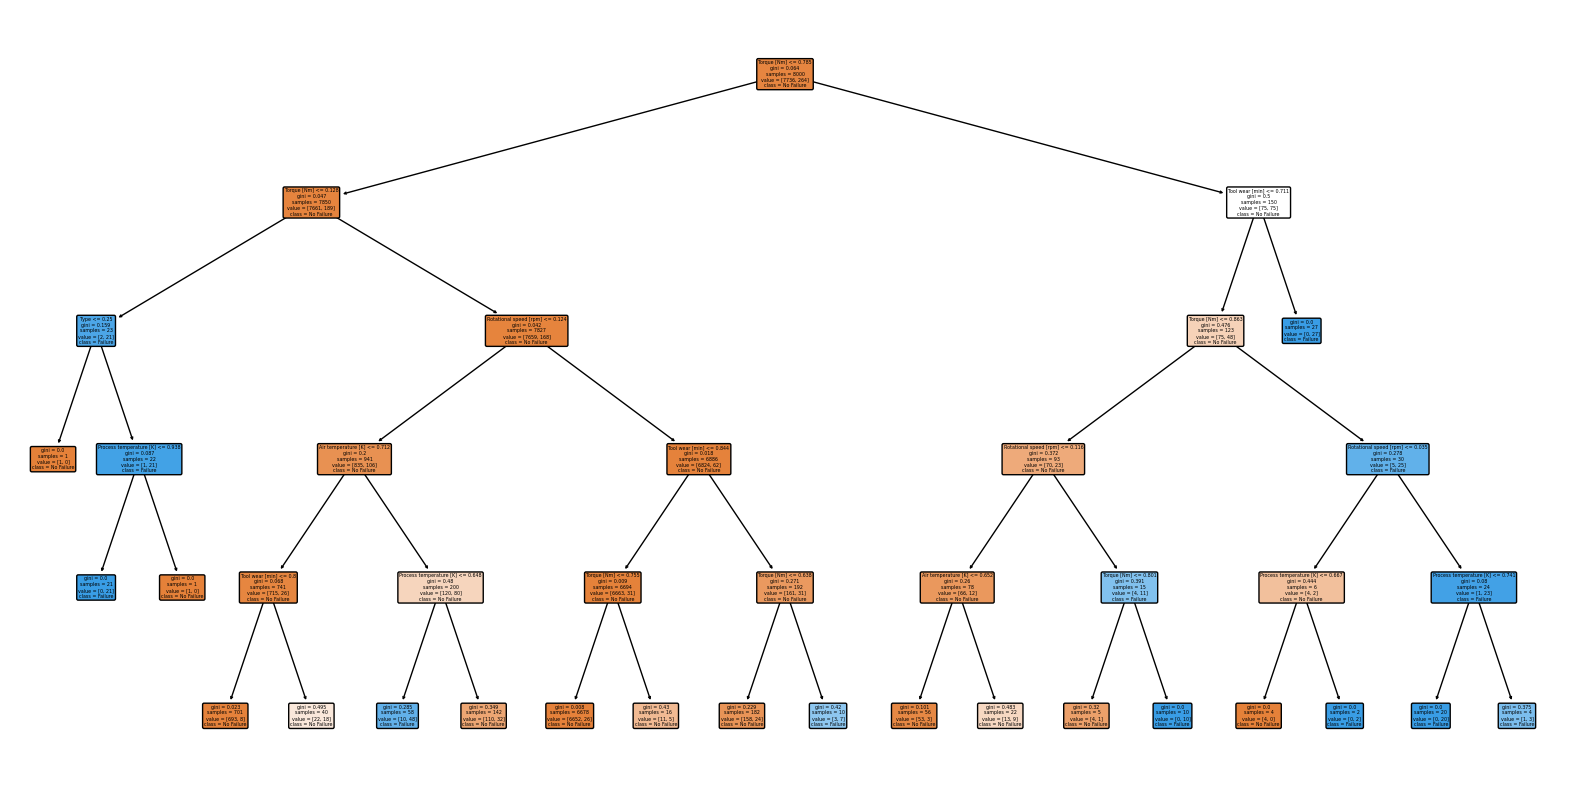

In [18]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt,
    feature_names=features.columns,
    class_names=["No Failure", "Failure"],
    filled=True,
    rounded=True,
);

The tree plot shows us how the model is making predictions. Each node represents a "question" being asked about the data. For instance, the first node is `Torque[Nm] <= 0.785`. For a given sample, if the measured torque is less than or equal to 0.785Nm, we follow the left branch, otherwise we follow the right branch. 

The `gini` value is a measure that indicates how many samples in each node are in a single class. A `gini` value of 0 means that all of the samples in the node are in the same class, while a value of 0.5 means that the samples are evenly split between the two classes. This is actually the same gini coefficient that is used to measure income inequality in economics.

**Your Turn**

Try changing the `max_depth` parameter of the decision tree model to see if you can improve the balanced accuracy score.

---

Let's try one more algorithm: a random forest. A random forest is an ensemble of decision trees, which means that it combines the predictions of multiple decision trees to improve the overall performance. It's typically more accurate than a single decision tree, but it's harder to interpret, since we can't visualize the entire forest.


In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
start_time = time()
rf.fit(x_train, y_train)
print(f'Training time: {time() - start_time:.2f}s')

false_negatives, false_positives = get_negatives_metrics(x_test, y_test, rf)
print(f"False Negatives: {false_negatives}, False Positives: {false_positives}")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, rf.predict(x_test)) * 100:.2f}%"
)

Training time: 0.49s
False Negatives: 29, False Positives: 7
Balanced accuracy: 80.48%


**Your Turn**

Is this better or worse than the decision tree? How do we decide?

## Interpreting the Model

One of the challenges with machine learning is that it can be difficult to understand how the model is making predictions. This is especially true for more complex algorithms, such as random forests. 

One way to get a sense of how the model is making predictions is to look at the feature importances. The feature importances indicate how much each feature contributes to the overall prediction. 

We can get the feature importances from the random forest model:

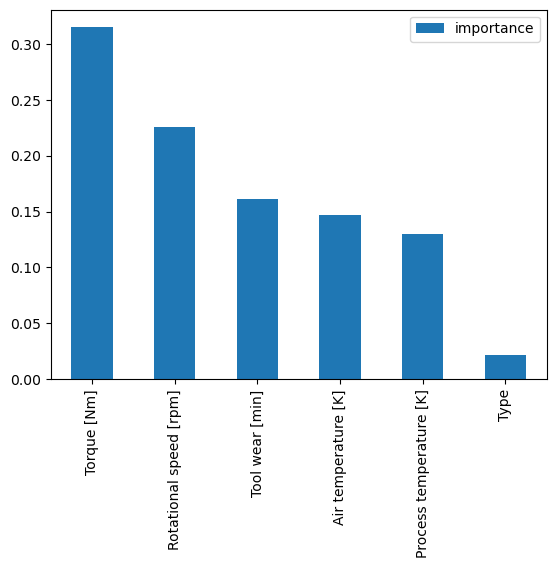

In [20]:
feature_importances = pd.DataFrame(
    rf.feature_importances_, index=x_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances.plot.bar();

As we can see, the `Torque [Nm]` feature is the most important in the model. Least important is the `Type` feature. Investigating feature importance is useful to understand which measurements are worth taking, and which might not be.

Another way to understand how the model is making predictions is to look at the partial dependence of the model on each feature. The partial dependence is the marginal effect of a feature on the predicted outcome. In other words, it shows us how the probability of failure changes as we change the value of a feature.

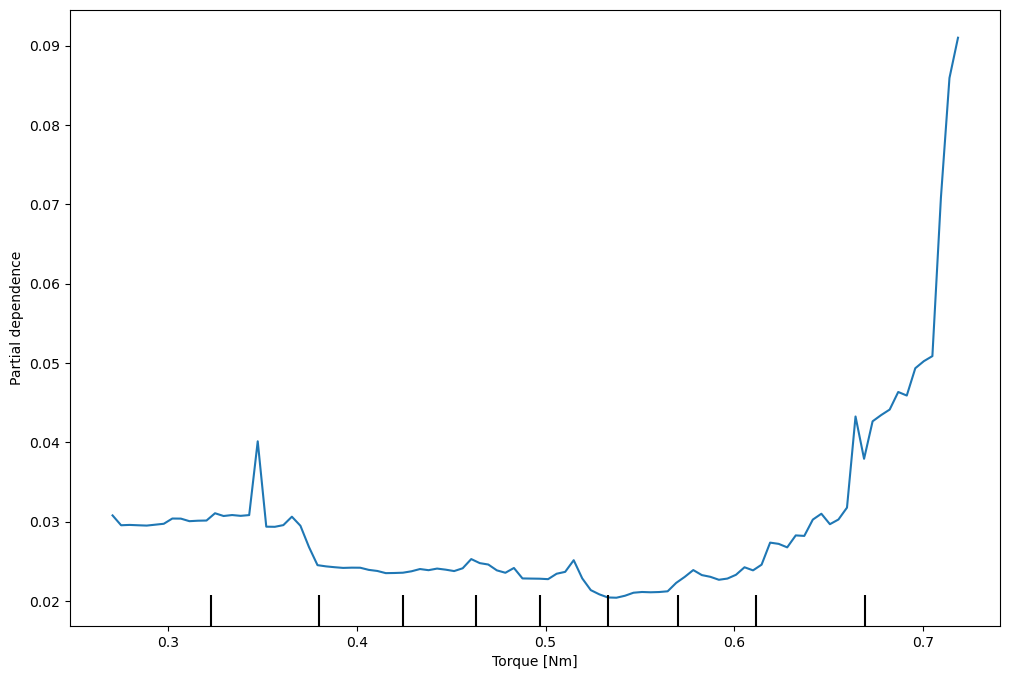

In [21]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))
disp = PartialDependenceDisplay.from_estimator(rf, x_train, ["Torque [Nm]"], ax=ax)

This plot shows us that as the torque increases, the probability of failure increases. Go ahead and try plotting the partial dependence for some of the other features.

## Predicting Failure Modes

So far, we have only been predicting whether the machine will fail or not. Let's see if we can predict the specific failure mode. We are going to use the random forest model that we trained above, but we are going to add the failure mode columns back into the features:

In [22]:
labels = data[["TWF", "HDF", "PWF", "OSF", "RNF"]]
features = data.drop(
    ["UDI", "Product ID", "Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"], axis=1
)

# Encode the Type column
features["Type"] = le.transform(features["Type"])
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, columns=features.columns)

# Split the data into training and test sets
x_train_modes, x_test_modes, y_train_modes, y_test_modes = train_test_split(
    features, labels, test_size=0.2, random_state=0
)

In [27]:
rf = RandomForestClassifier(
    max_depth=100, n_estimators=1000, max_features=10, random_state=0
)
start_time = time()
rf.fit(x_train_modes, y_train_modes)
print(f'Training time: {time() - start_time:.2f}s')

Training time: 18.13s


Since we now have 5 different failure modes, we need to use a different metric to evaluate the model. We can use the balanced accuracy score for each failure mode, and then average them together to get an overall score:

In [28]:
from sklearn.metrics import multilabel_confusion_matrix

y_hat = rf.predict(x_test_modes)
accuracies = []
for i, confusion in enumerate(multilabel_confusion_matrix(y_test_modes, y_hat)):
    print(labels.columns[i])
    print(f"False Negatives: {confusion[1, 0]}")
    print(f"False Positives: {confusion[0, 1]}")
    balanced_accuracy = balanced_accuracy_score(y_test_modes.iloc[:, i], y_hat[:, i])
    accuracies.append(balanced_accuracy)
    print(
        f"Balanced accuracy: {balanced_accuracy * 100:.2f}%"
    )
    print()
    
print(f"Average balanced accuracy: {np.mean(accuracies) * 100:.2f}%")

TWF
False Negatives: 10
False Positives: 2
Balanced accuracy: 49.95%

HDF
False Negatives: 1
False Positives: 0
Balanced accuracy: 97.73%

PWF
False Negatives: 2
False Positives: 1
Balanced accuracy: 94.42%

OSF
False Negatives: 9
False Positives: 4
Balanced accuracy: 80.33%

RNF
False Negatives: 4
False Positives: 0
Balanced accuracy: 50.00%

Average balanced accuracy: 74.49%


Looks like we are doing well at predicting the `HDF`, `PWF` and `OSF` failure modes, but not so well at predicting the `TWF` and `RNF` failure modes.

**Your Turn**

Try changing the parameters of the random forest model to see if you can improve the balanced accuracy score for the `TWF` and `RNF` failure modes. Some parameters that you might want to try changing are:

- `max_depth`: The maximum depth of each tree
- `n_estimators`: The number of trees in the forest
- `max_features`: The maximum number of features to consider when splitting a node (i.e. how many features to consider when asking a question about the data)

There are many others that you can find out more about in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

If you'd like to go further, you could also try using a different ensemble method. For documentation on the ensemble methods available in scikit-learn, see [here](https://scikit-learn.org/stable/modules/ensemble.html).

In [32]:
# Trying out another multi-label classifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

multi_rf = MultiOutputClassifier(gbc)
start_time = time()
multi_rf.fit(x_train_modes, y_train_modes)
print(f'Training time: {time() - start_time:.2f}s')

y_hat = multi_rf.predict(x_test_modes)
accuracies = []
for i, confusion in enumerate(multilabel_confusion_matrix(y_test_modes, y_hat)):
    print(labels.columns[i])
    print(f"False Negatives: {confusion[1, 0]}")
    print(f"False Positives: {confusion[0, 1]}")
    balanced_accuracy = balanced_accuracy_score(y_test_modes.iloc[:, i], y_hat[:, i])
    accuracies.append(balanced_accuracy)
    print(
        f"Balanced accuracy: {balanced_accuracy * 100:.2f}%"
    )
    print()
    
print(f"Average balanced accuracy: {np.mean(accuracies) * 100:.2f}%")

Training time: 2.69s
TWF
False Negatives: 10
False Positives: 5
Balanced accuracy: 49.87%

HDF
False Negatives: 1
False Positives: 2
Balanced accuracy: 97.68%

PWF
False Negatives: 2
False Positives: 4
Balanced accuracy: 94.34%

OSF
False Negatives: 5
False Positives: 4
Balanced accuracy: 89.03%

RNF
False Negatives: 4
False Positives: 2
Balanced accuracy: 49.95%

Average balanced accuracy: 76.17%


# Bonus: Testing Explainable Boosting Machines

As we discussed in the lecture, Explainable Boosting Machines (EBMs) are a relatively new machine learning algorithm that is designed to be more interpretable than other algorithms. Let's see if we can use an EBM to predict machine failure. We are going to use the [interpret](https://interpret.ml/) library from Microsoft to train the EBM, then we can compare its performance to the random forest model that we trained above.

In [33]:
!pip install -q -U interpret

In [34]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
start_time = time()
ebm.fit(x_train, y_train)
print(f'Training time: {time() - start_time:.2f}s')

Training time: 2.49s


As you can see, EBMs are much slower to train than random forests. The requirement that the model be interpretable comes at a cost of performance. Let's see how well it predicts:

In [35]:
false_negatives, false_positives = get_negatives_metrics(x_test, y_test, ebm)
print(f"False Negatives: {false_negatives}, False Positives: {false_positives}")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, ebm.predict(x_test)) * 100:.2f}%"
)

False Negatives: 36, False Positives: 9
Balanced accuracy: 75.77%


It's likely that the performance you're seeing is comparable or maybe a little worse than the random forest model. However, the EBM is much more interpretable. We can use the `explain_local` method of the `ExplainableBoostingClassifier` class to get a sense of how the model is making predictions for a given sample:

**Note: Under `Select Component to Graph`, you'll need to choose the second option to actually see the figure.**

In [36]:
from interpret import show

sample_x = x_test.iloc[0:1]
sample_y = y_test.iloc[0:1]

ebm_local = ebm.explain_local(sample_x, sample_y)
show(ebm_local)

/home/alex/mambaforge/envs/enbridge_general/lib/python3.11/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7195/140383988011728/ -->

This figure tells us precisely how each value in our input sample affected the ultimate prediction. As you go from top to bottom, the features are organized by the magnitude of their effect on this specific prediction. This is different from global feature importance, which tells us on average what features are most important. Most likely the first line will be the intercept - this is the underlying assumption of how likely failure is, given no other data. In this case, negative values reduce the likelihood of predicting failure, while positive values increase the likelihood of predicting failure.

Take some time to go through and see how each feature affects the prediction. You can also try changing the sample to see how the prediction changes.

Another valuable tool for understanding how the model is making predictions is the `explain_global` method. This method shows us the global feature importance, as well as the partial dependence of each feature. The partial dependence is the marginal effect of a feature on the predicted outcome. We calculated these metrics on our random forests before, but there's a key difference here - in our earlier models, we were _estimating_ the partial dependence, but in the EBM, we are _measuring_ the partial dependence. Because the EBM is interpretable, we can directly measure the partial dependence, rather than estimating it.

In [37]:
from interpret import show

ebm_global = ebm.explain_global()

show(ebm_global)

/home/alex/mambaforge/envs/enbridge_general/lib/python3.11/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7195/140383976756880/ -->